<a href="https://colab.research.google.com/github/goflvhxj/CIFAR100-with-NoisyLabel/blob/main/PENCIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. dataset**

In [ ]:
import numpy as np
import torchvision
import pandas as pd
from PIL import Image
import os
from glob import glob

# csv 파일에서 이미지 경로, 라벨 불러오기
columns = ['file_path', 'label']
all = pd.read_csv('./Yonsei-vnl-coding-assignment-vision-48hrs/dataset/data/cifar100_nl.csv', names=columns)
test = pd.read_csv('./Yonsei-vnl-coding-assignment-vision-48hrs/dataset/data/cifar100_nl_test.csv', names=columns)

# train label만 남김
dropna_train = all.dropna(axis=0)
dropna_train.head()

# 경로명 저장
train = dropna_train.sort_values(by=['file_path'])
test = test.sort_values(by=['file_path'])

# class별 갯수 확인
class_counts = train['label'].value_counts().to_dict()

# 클래스에 각각에 대한 숫자형 라벨을 생성
label_map = {name: i for i, (name, count) in enumerate(class_counts.items())}


# train data 불러오기
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:(x.split('/')[-1].split('.')[0]))
        
    # get label
    label_list.extend(train['label'])
                
    return img_path_list, label_list


# test data 불러오기
def get_test_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:(x.split('/')[-1].split('.')[0]))
    #print(img_path_list)

    # get label
    label_list.extend(test['label'])
    
    return img_path_list, label_list  


train_img_path, train_label = get_train_data('./Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/train')
test_img_path, test_label = get_test_data('./Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/test')


# object형태의 label을 int형으로 변환
labels = train_label
int_train_labels = [label_map[label] for label in labels]

labels2 = test_label
int_test_labels = [label_map[label] for label in labels2]



In [ ]:
print('train_img_path : ', train_img_path[:5])
print('train_label : ', int_train_labels[:5])
print('test_img_path : ', test_img_path[:5])
print('test_label : ', int_test_labels[:5])

train_img_path :  ['./Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/train/AAAMhtuLlg.png', './Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/train/AAEKhSzYjb.png', './Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/train/AAFmznqStg.png', './Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/train/AAHSUlwrdk.png', './Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/train/AAHorghNrg.png']
train_label :  [83, 85, 33, 51, 7]
test_img_path :  ['./Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/test/AAAskyGhWB.png', './Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/test/AAByKXraYf.png', './Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/test/AAdUmVFbWd.png', './Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/test/AAjZvAvIkB.png', './Yonsei-vnl-coding-assignment-vision-48hrs/dataset/cifar100_nl/img/test/ABDJDuRwPn.png']
test_label : 

## **2. resnet**

In [ ]:
import torch.nn as nn
import math


def _conv2d_bn(in_channels, out_channels, kernel_size, stride, padding):
    conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    bn = nn.BatchNorm2d(num_features=out_channels)
    return nn.Sequential(conv, bn)


def _conv2d_bn_relu(in_channels, out_channels, kernel_size, stride, padding):
    conv2d_bn = _conv2d_bn(in_channels, out_channels, kernel_size, stride, padding)
    relu = nn.ReLU(inplace=True)
    layers = list(conv2d_bn.children())
    layers.append(relu)
    return nn.Sequential(*layers)


class _BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downscale=False):
        super(_BasicBlock, self).__init__()
        self.down_sampler = None
        stride = 1
        if downscale:
            self.down_sampler = _conv2d_bn(in_channels, out_channels, kernel_size=1, stride=2, padding=0)
            stride = 2
        self.conv_bn_relu1 = _conv2d_bn_relu(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        # don't relu here! relu on (H(x) + x)
        self.conv_bn2 = _conv2d_bn(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu_out = nn.ReLU(inplace=True)
        # residual = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        # residual = nn.BatchNorm2d(num_features=out_channels)
        # residual = nn.ReLU(inplace=True)

    def forward(self, x):
        input = x
        if self.down_sampler:
            input = self.down_sampler(x)
        residual = self.conv_bn_relu1(x)
        residual = self.conv_bn2(residual)
        out = self.relu_out(input + residual)
        return out


class _ResNet(nn.Module):
    def __init__(self, num_layer_stack):
        super(_ResNet, self).__init__()
        self.conv1 = _conv2d_bn_relu(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.layer1 = self.__make_layers(num_layer_stack, in_channels=16, out_channels=16, downscale=False)
        self.layer2 = self.__make_layers(num_layer_stack, in_channels=16, out_channels=32, downscale=True)
        self.layer3 = self.__make_layers(num_layer_stack, in_channels=32, out_channels=64, downscale=True)
        self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1)
        self.fc = nn.Linear(in_features=64, out_features=100)

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()

    def __make_layers(self, num_layer_stack, in_channels, out_channels, downscale):
        layers = []
        layers.append(_BasicBlock(in_channels=in_channels, out_channels=out_channels, downscale=downscale))
        for i in range(num_layer_stack - 1):
            layers.append(_BasicBlock(in_channels=out_channels, out_channels=out_channels, downscale=False))
        return nn.Sequential(*layers)

    def forward(self, x):
        y = self.conv1(x)
        y = self.layer1(y)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.avgpool(y)
        y = y.view(y.size(0), -1)
        y = self.fc(y)
        return y


def resnet20():
    return _ResNet(num_layer_stack=3)


def resnet32():
    return _ResNet(num_layer_stack=5)


def resnet56():
    return _ResNet(num_layer_stack=9)

## **3.pencil**

In [ ]:
import torch
from torch import nn
from torch import optim
import numpy as np
import copy as cp

class PENCIL():
    def __init__(self, all_labels_tensor, n_samples, n_classes, n_epochs, lrs, alpha, beta, gamma, K, save_losses=False, use_KL=True):
        '''
        all_labels_tensor: torch tensor, 1-D tensor of labels indexed as in the training dataset object
        n_samples: int, length of training dataset
        n_epochs: list of positive ints, number of epochs of phases in form [n_epochs_i for i in range(3)]
        lrs: list of floats, learnings rates for phases in form [lr_i for i in range(3)]
        alpha: coefficient for lo loss
        beta: coefficient for le loss
        gamma: coefficient for label estimate update
        K: int, learning rate multiplier for label estimate updates
        save_losses: bool, whether to save losses into list of lists of form [[lc,lo,le] for e in *phase 2 epochs*]
        use_KL: bool, whether to use KL loss or crossentropy for phase 3
        '''
        
        self.save_losses = save_losses
        self.use_KL = use_KL
        self.n_epochs = n_epochs
        self.lrs = lrs
        self.n_classes = n_classes
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.K = K
        
        self.CELoss = nn.CrossEntropyLoss()
        self.KLLoss = nn.KLDivLoss(reduction='mean') #PENCIL official implementation uses mean, not batchmean
        self.softmax = nn.Softmax(dim=1)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self._init_y_tilde(all_labels_tensor)
        self.y_prev = None
        self.losses = []
        
    def _init_y_tilde(self, all_labels_tensor):
        '''
        all_labels_tensor: torch tensor, 1-D tensor of labels indexed as in the training dataset object
        '''
        labels_temp = torch.zeros(all_labels_tensor.size(0), self.n_classes).scatter_(1, all_labels_tensor.view(-1, 1).long(), self.K)
        self.y_tilde = labels_temp.numpy()
        
    def set_lr(self, optimizer, epoch):
        '''
        Call before inner training loop to update lr based on PENCIL phase
        '''
        lr = -1
        if epoch == 0: lr = self.lrs[0] # Phase 1
        elif epoch == self.n_epochs[0]: lr = self.lrs[1] # Phase 2
        elif epoch == self.n_epochs[0]+self.n_epochs[1]: lr = self.lrs[2] # Phase 3 
        elif epoch == self.n_epochs[0]+self.n_epochs[1]+self.n_epochs[2]//3: # Phase 3 first decay
            lr = self.lrs[2]/10
        elif epoch == self.n_epochs[0]+self.n_epochs[1]+2*self.n_epochs[2]//3: # Phase 3 second decay
            lr = self.lrs[2]/100
#         elif epoch == 300:
#             lr = sel.flrs[2]/1000
            
        if lr!=-1:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    
    def get_loss(self, epoch, outputs, labels, indices):
        '''
        outputs: un-normalized logits 
        labels: cuda tensor of noisy labels
        indices: cpu tensor of indices for current batch
        '''
        # Calculate loss based on current phase
        if epoch < self.n_epochs[0]: #Phase 1
            lc = self.CELoss(outputs, labels)
        else:
            self.y_prev = cp.deepcopy(self.y_tilde[indices,:]) #Get unnormalized label estimates
            self.y_prev = torch.tensor(self.y_prev).float()
            self.y_prev = self.y_prev.cuda(non_blocking=True)
            self.y_prev.requires_grad = True
            
            # obtain label distributions (y_hat)
            y_h = self.softmax(self.y_prev)
            if epoch<self.n_epochs[0]+self.n_epochs[1] or self.use_KL: # During phase 1. 
                lc = self.KLLoss(self.logsoftmax(self.y_prev),self.softmax(outputs))
                ########## 여기부터 ###############
#                 lc = torch.mean(self.softmax(outputs)*(self.logsoftmax(outputs)-torch.log((y_h))))
                ######### 여기까지 ###################
            else: # During phase 2 use CE if self.use_KL=False
                lc = self.CELoss(self.softmax(outputs),self.softmax(y_h))
            lo = self.CELoss(y_h, labels) # lo is compatibility loss
            le = - torch.mean(torch.mul(self.softmax(outputs), self.logsoftmax(outputs))) # le is entropy loss
        # Compute total loss
        if epoch < self.n_epochs[0]:
            loss = lc
        elif epoch < self.n_epochs[0]+self.n_epochs[1]:
            loss = lc + self.alpha * lo + self.beta * le
            if self.save_losses: self.losses.append([lc.item(),lo.item(),le.item()])
        else:
            loss = lc
        return loss
    
    def update_y_tilde(self, epoch, indices):
        '''
        Call this after the backward pass over the loss
        ''' 
        # If in phase 2, update y estimate
        if epoch >= self.n_epochs[0] and epoch < self.n_epochs[0]+self.n_epochs[1]:
            # update y_tilde by back-propagation
            self.y_tilde[indices]+=-self.gamma*self.y_prev.grad.data.cpu().numpy()

## **4. utils**

In [ ]:
import sklearn
import numpy as np
import copy as cp
import sklearn.metrics

def get_performance_metrics(num_classes, preds, label_list, metrics=['acc','auprc','auroc'], rounding=4):
    '''
    num_classes: integer
    metrics: list of strings. subset of ['acc','auprc','auroc'] 
    '''

    results = dict()
    if 'auprc' in metrics or 'auroc' in metrics:
        if num_classes>2:
            Y_byclass = [np.array([[0,1] if row==l else [1,0] for row in label_list]) for l in range(num_classes)]
            pred_byclass = [cp.deepcopy(preds) for i in range(num_classes)]
            for j in range(num_classes):
                other = np.sum(pred_byclass[j][:,[i for i in range(num_classes) if i!=j]],axis=1)
                pred_byclass[j][:,1] = pred_byclass[j][:,j]
                pred_byclass[j][:,0] = other
                pred_byclass[j] = pred_byclass[j][:,[0,1]]
                
    for metric in metrics:
        if metric=='acc': results[metric] = round(sklearn.metrics.accuracy_score(label_list,np.argmax(preds,axis=1)),rounding)
        elif metric=='auprc': 
            if num_classes>2: results[metric] = round(np.mean([sklearn.metrics.average_precision_score(Y_byclass[cl],pred_byclass[cl]) for cl in range(num_classes)]),rounding)
            else: results[metric] = round(sklearn.metrics.average_precision_score(label_list,preds[:,1]),rounding)
        elif metric=='auroc':
            if num_classes>2: results[metric] = round(np.mean([sklearn.metrics.roc_auc_score(Y_byclass[cl],pred_byclass[cl]) for cl in range(num_classes)]),rounding)
            else: results[metric] = round(sklearn.metrics.roc_auc_score(label_list,preds[:,1]),rounding)
                
    return results

## **5. main**

In [ ]:
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import torch.nn as nn
from scipy.special import softmax
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import copy as cp
import os
import cv2
import pickle
import numpy as np

torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


class C100Dataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, idx): #index번째 data를 return
        img_path = self.img_path_list[idx]
        # Get image data
        #print(img_path)
        image = cv2.imread(img_path)
        image = Image.fromarray(image)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[idx]
            return image, label, idx
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

    
if True: # Define hyper parameters
    epochs = 320
    batch_size = 128
    lr = 0.01
    momentum = 0.9
    weight_decay = 10e-4
    n_classes = 100
    pencil_epochs = [70, 130, 120]
    pencil_lrs = [0.01, 0.01, 0.01]
    pencil_alpha, pencil_beta, pencil_gamma = 0.1, 0.4, 600
    pencil_KL = True
    pencil_K = 200
    checkpoint = 5
    start_epoch = 0
    seed = 1
    train_ratio = 0.9
    asym_noise = True
    noise_ratio = 0.2
    temp_path = './checkpoint/'

cudnn.benchmark = True

if True: # Define dataset and transforms
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    np.random.seed(seed)
    trainset = C100Dataset(train_img_path, int_train_labels, train_mode=True, transforms=transform_train) 
    valset = C100Dataset(test_img_path, int_test_labels, train_mode=True, transforms=transform_val) 
    
    if start_epoch==0: # 
        print('trainset',len(trainset))
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)


######### Model checkpointing commented out
        with open(temp_path+"trainloader"+".pkl", "wb") as file:
            pickle.dump(trainloader,file)
        with open(temp_path+"valloader"+".pkl", "wb") as file:
            pickle.dump(valloader,file)
    else: 
        with open(temp_path+"trainloader"+".pkl", "rb") as file:
            trainloader = pickle.load(file)
        with open(temp_path+"valloader"+".pkl", "rb") as file:
            valloader = pickle.load(file)

if True: # Define Model and optimizer

    # Model
    print("==> creating preact_resnet")
    model = resnet56()
    model = model.cuda()
    print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

if True: # Define dict for storing results
    results = {'train':None,'val':None}
    metrics = ['acc','auprc','auroc','loss']
    for subset in results.keys(): 
        results[subset] = {metric:[] for metric in metrics}

    results['pencil_labels'], results['labels'], results['true_labels'] = [], [], []
    results['pencil_label_drift'], results['pencil_label_correct'] = [], []
    for i in range(len(trainset)): 
        item = trainset.__getitem__(i)
        results['labels'].append(item[1])
#         results['true_labels'].append(item[3])
        
if True: # Define PENCIL
    pencil = PENCIL(torch.tensor(results['labels']), len(trainset), n_classes, pencil_epochs, pencil_lrs, 
                                    pencil_alpha, pencil_beta, pencil_gamma, save_losses=True, use_KL=pencil_KL,
                                    K=pencil_K)

######### Model checkpointing commented out
if start_epoch>0: # Load checkpoint data
    model.load_state_dict(torch.load(temp_path+'epoch'+str(start_epoch)))
    with open(temp_path+"results"+str(start_epoch)+".pkl", "rb") as file:
        results = pickle.load(file)
    with open(temp_path+"pencil"+str(start_epoch)+".pkl", "rb") as file:
        pencil = pickle.load(file)
    pencil.alpha=pencil_alpha
    pencil.beta=pencil_beta
    
for epoch in range(start_epoch,epochs):
    if True: # Train 
        pencil.set_lr(optimizer, epoch)
        model.train()
        preds, label_list = [], []
        if epoch in pencil_epochs: results['pencil_labels'].append(cp.deepcopy(pencil.y_tilde))

        for batch_idx, (inputs, labels, inds) in enumerate(trainloader):
            ############## 여기 추가 ##################
            inds = inds.numpy()
            ###############여기까지 ###################
            inputs, labels = inputs.cuda(), labels.cuda(non_blocking = True)
            outputs = model(inputs)
            
            
            loss = pencil.get_loss(epoch, outputs, labels, inds)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pencil.update_y_tilde(epoch, inds)
            preds.append(outputs.detach())
            label_list.append(labels.cpu())

        label_list = np.vstack(torch.cat(label_list).numpy())
        preds = softmax(np.vstack(torch.cat(preds).cpu().numpy()), axis=1)
        train_results = get_performance_metrics(num_classes=n_classes,preds=preds,label_list=label_list)
        for result in train_results.keys():
            results['train'][result].append(train_results[result])
        label_drift = round(sum(results['labels']==np.argmax(pencil.y_tilde,axis=1))/len(results['labels']),4)
#         label_true_corr = round(sum(results['true_labels']==np.argmax(pencil.y_tilde,axis=1))/len(results['true_labels']),4)
        results['pencil_label_drift'].append(label_drift)
#         results['pencil_label_correct'].append(label_true_corr)
    
    if True: # Val
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch_idx, (inputs, labels, _) in enumerate(valloader):
                inputs, labels = inputs.cuda(), labels
                outputs = model(inputs)
                val_preds.append(outputs)
                val_labels.append(labels)
        val_labels = np.vstack(torch.cat(val_labels).numpy())
        val_preds = softmax(np.vstack(torch.cat(val_preds).cpu().numpy()), axis=1)
        val_results = get_performance_metrics(num_classes=n_classes,preds=val_preds,label_list=val_labels)
        for result in val_results.keys():
            results['val'][result].append(val_results[result])

    if True: # Print results 
        print('Epoch', epoch, 'Current LR', round(optimizer.param_groups[0]['lr'],5))
        if epoch>=pencil_epochs[0]:
            print('Percent of estimated labels that have remained the same since end of phase 1',round(sum(np.argmax(results['pencil_labels'][0],axis=1)==np.argmax(pencil.y_tilde,axis=1))/len(results['pencil_labels'][0]),4))
        print('% y_tilde equal to noisy label',results['pencil_label_drift'][-1])
#         print('% y_tilde equal to true label',results['pencil_label_correct'][-1])
        print('Train acc %.3f, Train auroc %.3f' % (results['train']['acc'][-1], results['train']['auroc'][-1]))
        print('Val acc %.3f, Val auroc %.3f' % (results['val']['acc'][-1], results['val']['auroc'][-1]))                                                                 

######### Model checkpointing commented out
    if checkpoint!=None and (epoch%checkpoint==0 or epoch+1 in pencil_epochs): #Save model for this epoch
        if epoch%checkpoint==0 and epoch>start_epoch+checkpoint: 
            os.remove(temp_path+'epoch'+str(epoch-checkpoint))
            os.remove(temp_path+"results"+str(epoch-checkpoint)+".pkl")
            os.remove(temp_path+"pencil"+str(epoch-checkpoint)+".pkl")
        torch.save(model.state_dict(), temp_path+'epoch'+str(epoch))
        with open(temp_path+"results"+str(epoch)+".pkl", "wb") as file:
            pickle.dump(results,file)
        with open(temp_path+"pencil"+str(epoch)+".pkl", "wb") as file:
            pickle.dump(pencil,file)

trainset 49999
==> creating preact_resnet
Total params: 0.86M
Epoch 0 Current LR 0.01
% y_tilde equal to noisy label 1.0
Train acc 0.038, Train auroc 0.654
Val acc 0.073, Val auroc 0.778
Epoch 1 Current LR 0.01
% y_tilde equal to noisy label 1.0
Train acc 0.081, Train auroc 0.744
Val acc 0.113, Val auroc 0.848


KeyboardInterrupt: 

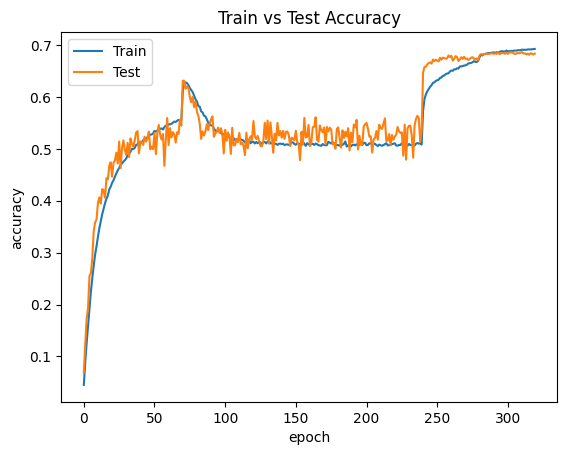

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results['train']['acc'])
plt.plot(results['val']['acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
plt.show()